In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-reviews/Reviews.csv


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split



# 1. Data Ingestion and Preprocessing:

In [64]:
df=pd.read_csv("/kaggle/input/amazon-product-reviews/Reviews.csv")

In [65]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [67]:
df.shape

(568454, 10)

#### Removing unneccessary Columns

In [68]:
df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'],axis=1,inplace=True)

In [69]:
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [70]:
## Checking Missing Values
df.isna().sum()

Score    0
Text     0
dtype: int64

In [11]:

print('Number of Duplicate in the dataset:',df.duplicated().sum())

Number of Duplicate in the dataset: 174779


#### Here no **missing** values but  have **duplicate** values, need to be removed

In [71]:
df.drop_duplicates(inplace=True)

In [72]:
df.duplicated().sum()

0

In [73]:
df.shape

(393675, 2)

### EDA ( Exploratery Data Analysis)

In [74]:
df['Score'].unique()

array([5, 1, 4, 2, 3])

<Axes: xlabel='Score', ylabel='count'>

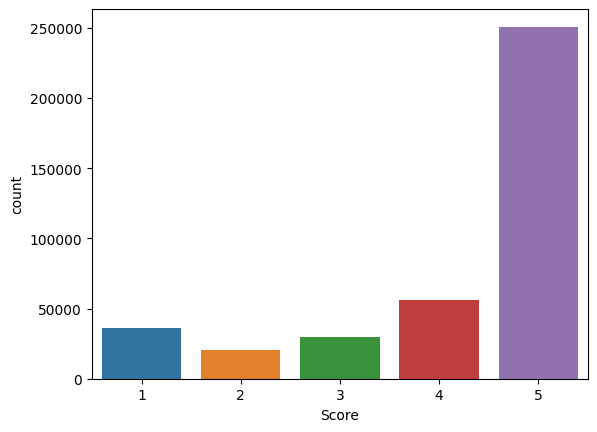

In [16]:
sns.countplot(x=df['Score'])

#### Here We can Majority class is 5 , imbalanced classes in the dataset

In [17]:
df['Score'].value_counts()

Score
5    250745
4     56074
1     36280
3     29772
2     20804
Name: count, dtype: int64

In [18]:
df['Score'].value_counts()/len(df)*100

Score
5    63.693402
4    14.243729
1     9.215724
3     7.562583
2     5.284562
Name: count, dtype: float64

### observation 
#### 63% value scores are 5 in the dataset, so high volume of product reviews are positve

### Taking Samples from each scores 

In [93]:
df1=df.groupby('Score').apply(lambda x: x.sample(20800)).reset_index(drop=True)

<ipython-input-93-0faaced037b7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1=df.groupby('Score').apply(lambda x: x.sample(20800)).reset_index(drop=True)


#### By taking **20800** samples from each **score** , the data become balanced and we have 104000 raw data

In [75]:
df1.shape

(104000, 3)

In [21]:
df1['Score'].value_counts()

Score
1    20800
2    20800
3    20800
4    20800
5    20800
Name: count, dtype: int64

<Axes: xlabel='Score', ylabel='count'>

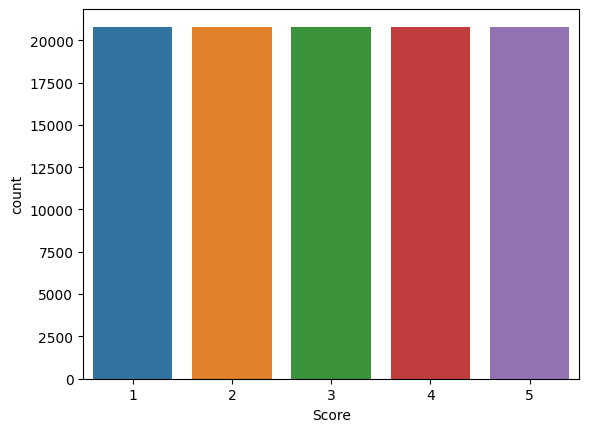

In [22]:
sns.countplot(x=df1['Score'])

##### As shown,```Score``` Column is balanced and each value have the same distribution so the model won't be biased to specific value.

### Text Preprocessing

In [76]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer,PorterStemmer


In [77]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
stop_words=set(stopwords.words('english'))

In [26]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [79]:
stemming=PorterStemmer()

In [80]:
def preprocess_text(text):
    # convert text into lower
    text=text.lower()

    # make tokens ( words)
    tokens=word_tokenize(text)

    # Remove punctuations (like: , ? , etc)
    tokens=[word for word in tokens if word not in string.punctuation]

    # Remove stopwords ( like : is , am , for ,etc
    tokens =[word for word in tokens if word not in stop_words]

    # Remove numbers
    tokens=[word for word in tokens if not word.isdigit()]

    # apply stemming
    tokens=[stemming.stem(word) for word in tokens]

    return ' '.join(tokens)
    

In [94]:
df1['cleaned_text']=df1['Text'].apply(preprocess_text)

In [95]:
# save the cleaned text
df1.to_csv('df1.csv')

In [96]:
df2=pd.read_csv('/kaggle/working/df1.csv')

In [97]:
df2['Score'].value_counts()

Score
1    20800
2    20800
3    20800
4    20800
5    20800
Name: count, dtype: int64

In [98]:
df2.head()

,Unnamed: 0,Score,Text,cleaned_text
0,0,1,It has a sweet aftertaste that I just can't to...,sweet aftertast ca n't toler made press tri fi...
1,1,1,While the item is decent looking and holds the...,item decent look hold brewer fine close well p...
2,2,1,ive been reading about a salmonella recall wit...,ive read salmonella recal product dog complet ...
3,3,1,I bought these after hearing all of the raves ...,bought hear rave arriv look like worm water ba...
4,4,1,The cans arrived all banged up. I will never ...,can arriv bang never order compani


In [99]:
df2['Score'] = df2['Score'].apply(lambda x: 0 if x < 3 else (1 if x == 3 else 2))


In [100]:
df2['Score'].value_counts()

Score
0    41600
2    41600
1    20800
Name: count, dtype: int64

In [122]:
X=df2['cleaned_text']
y=df2['Score']

In [104]:
set(y)

{0, 1, 2}

### Vectorization and Modeling

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report


In [124]:
# Split the data set into two part for training and testing 
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state = 42,test_size = 0.20)


{0}

In [107]:
log_model=LogisticRegression()
log_model.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [108]:
log_pred=log_model.predict(x_test)
print('Training accuracy:', log_model.score(x_train,y_train))
print('Testing accuracy:',log_model.score(x_test,y_test))

Training accuracy: 0.7618269230769231
Testing accuracy: 0.6806730769230769


<Axes: >

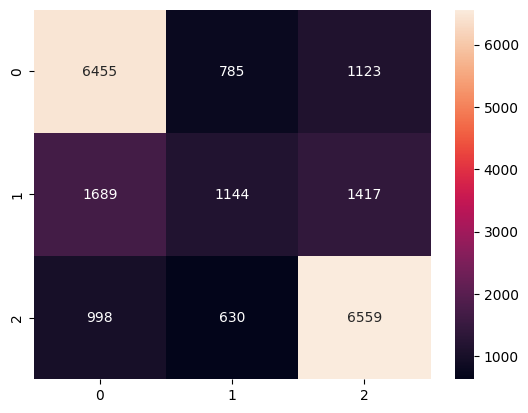

In [109]:
sns.heatmap(confusion_matrix(y_test,log_pred), annot=True, fmt="d")


In [119]:
logistic_pipe=Pipeline(
    [
      ('vec',CountVectorizer(stop_words= "english")),
        ('Tf_idf',TfidfTransformer()),
        ('log_rg',LogisticRegression()),

    ]
)

In [125]:
log_fit = logistic_pipe.fit(x_train,y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [126]:
log_pred=logistic_pipe.predict(x_test)


In [129]:
print('Training accuracy:', log_fit.score(x_train,y_train))
print('Test accuracy:', log_fit.score(x_test,y_test))


Training accuracy: 0.7452764423076923
Test accuracy: 0.6910096153846154


<Axes: >

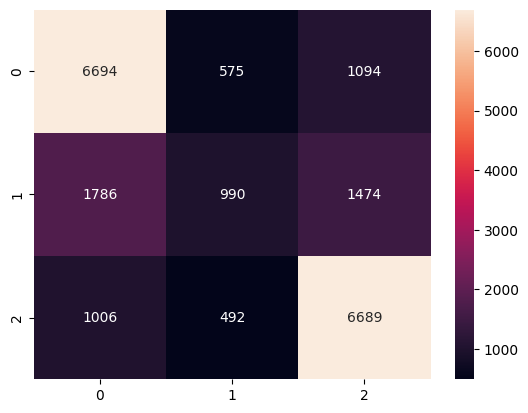

In [130]:
sns.heatmap(confusion_matrix(y_test,log_pred), annot=True, fmt="d")


In [132]:
print(classification_report(y_test, log_pred,digits=4))


              precision    recall  f1-score   support

           0     0.7057    0.8004    0.7501      8363
           1     0.4813    0.2329    0.3139      4250
           2     0.7226    0.8170    0.7669      8187

    accuracy                         0.6910     20800
   macro avg     0.6365    0.6168    0.6103     20800
weighted avg     0.6665    0.6910    0.6676     20800



### Here we can see the nuetral class accuracy is very low , because of imbalanced class